In [1]:
pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 6.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 27.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 34.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


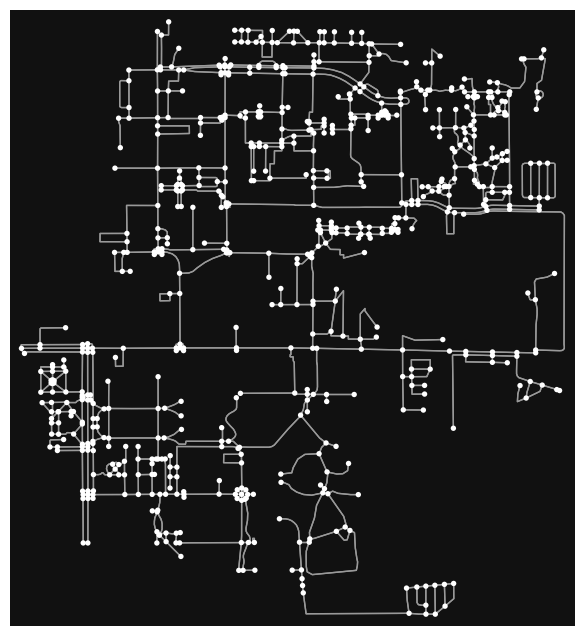

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
import osmnx as ox
import os

custom_cache = os.path.expanduser("~/Desktop/osmnx_cache")
ox.settings.cache_folder = custom_cache
ox.settings.use_cache = True

# Plot Graph from places extracted from maps
place_name = "Claremont Colleges, Claremont, California, USA"
G = ox.graph_from_place(place_name, network_type='walk')
ox.plot_graph(G)

In [6]:
import osmnx as ox
print(ox.__version__)

2.0.2


<Axes: >

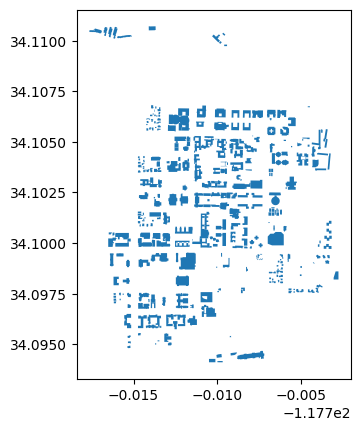

In [9]:
tags = {"building": True}
gdf_buildings = ox.features_from_place("Claremont Colleges, Claremont, California, USA", tags)
gdf_buildings.plot()

In [ ]:
# Create node graph using building edges closest to road
import networkx as nx
G_buildings = nx.Graph()

for idx, building in gdf_buildings.iterrows():
    name = building.get("name", f"building_{idx}")
    geom = building.geometry

    # Find the nearest point on a road to the building (projecting it to the nearest road)
    nearest_geom = gdf_drive.geometry.unary_union
    nearest_point = nearest_points(geom, nearest_geom)[1]

    # Add this projected point as the node position
    G_buildings.add_node(name, pos=(nearest_point.y, nearest_point.x))  # (lat, lon)


In [16]:
from itertools import permutations

def is_hamiltonian_path(G, path):
    return all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1))

def find_hamiltonian_path(G):
    nodes = list(G.nodes())
    for perm in permutations(nodes):
        if is_hamiltonian_path(G, perm):
            return list(perm)  # return the path if found
    return None  # no Hamiltonian path


In [17]:
def is_hamiltonian_cycle(G, path):
    return is_hamiltonian_path(G, path) and G.has_edge(path[-1], path[0])

def find_hamiltonian_cycle(G):
    nodes = list(G.nodes())
    for perm in permutations(nodes):
        if is_hamiltonian_cycle(G, perm):
            return list(perm)
    return None

In [18]:
def has_eulerian_circuit(G):
    return nx.is_eulerian(G)

def has_eulerian_path(G):
    return nx.has_eulerian_path(G)

def get_eulerian_path(G):
    if has_eulerian_path(G):
        return list(nx.eulerian_path(G))
    return None

def get_eulerian_circuit(G):
    if has_eulerian_circuit(G):
        return list(nx.eulerian_circuit(G))
    return None


In [19]:
def draw_path_on_map(G, path, pos, base_graph=None):
    plt.figure(figsize=(12, 12))
    
    # Optionally plot a base graph (e.g., OSM streets)
    if base_graph:
        fig, ax = ox.plot_graph(base_graph, show=False, close=False, edge_color='lightgray')
    else:
        ax = plt.gca()

    # Draw the full graph
    nx.draw(G, pos, ax=ax, node_color='lightgray', node_size=30, with_labels=False)

    # Highlight the path
    edges_in_path = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges_in_path, ax=ax, edge_color='red', width=2)
    nx.draw_networkx_nodes(G, pos, nodelist=path, ax=ax, node_color='blue', node_size=50)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)
    
    plt.title("Highlighted Path")
    plt.show()

In [20]:
# Get positions
pos = nx.get_node_attributes(G_buildings, "pos")

# ---- Eulerian ----
print("Eulerian Circuit:", has_eulerian_circuit(G_buildings))
print("Eulerian Path:", has_eulerian_path(G_buildings))

euler_path = get_eulerian_path(G_buildings)
if euler_path:
    euler_node_path = [u for u, v in euler_path] + [euler_path[-1][1]]
    draw_path_on_map(G_buildings, euler_node_path, pos, title="Eulerian Path")

# ---- Hamiltonian ----
# Be careful: this is factorial time complexity!
if len(G_buildings.nodes) <= 9:
    hamilton_path = find_hamiltonian_path(G_buildings)
    if hamilton_path:
        print("Hamiltonian Path Found:", hamilton_path)
        draw_path_on_map(G_buildings, hamilton_path, pos, title="Hamiltonian Path")
    else:
        print("No Hamiltonian Path Found.")
else:
    print("Too many nodes to check for Hamiltonian Path via brute force.")


Eulerian Circuit: False
Eulerian Path: False
Too many nodes to check for Hamiltonian Path via brute force.


In [21]:
# Define your list of roads
allowed_streets = {"Platt Blvd", "Mills Avenue", "9th Street", "Columbia Avenue", "College Way", "6th Street", "Harrison Avenue", "College Avenue", "Amherst Avenue", "Claremont Blvd"}

# Build a filtered graph
G_filtered = G.edge_subgraph([
    (u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
    if 'name' in data and (
        isinstance(data['name'], str) and data['name'] in allowed_streets or
        isinstance(data['name'], list) and any(name in allowed_streets for name in data['name'])
    )
]).copy()


In [24]:
from itertools import permutations
import networkx as nx

# Converts a MultiGraph/MultiDiGraph to a simple undirected graph
G_simple = nx.Graph(G_filtered)

def count_hamiltonian_paths(G):
    nodes = list(G.nodes)
    count = 0
    for perm in permutations(nodes):
        valid = True
        for i in range(len(perm) - 1):
            if not G.has_edge(perm[i], perm[i + 1]):
                valid = False
                break
        if valid:
            count += 1
    return count

if G_simple.number_of_nodes() <= 10:
    total_paths = count_hamiltonian_paths(G_simple)
    print(f"Total Hamiltonian paths: {total_paths}")
else:
    print("Graph too large to enumerate Hamiltonian paths exactly.")

Graph too large to enumerate Hamiltonian paths exactly.


In [25]:
def hamiltonian_path_backtrack(G, path, visited, all_paths):
    if len(path) == len(G):
        all_paths.append(list(path))
        return

    for neighbor in G.neighbors(path[-1]):
        if neighbor not in visited:
            visited.add(neighbor)
            path.append(neighbor)
            hamiltonian_path_backtrack(G, path, visited, all_paths)
            path.pop()
            visited.remove(neighbor)

def count_hamiltonian_paths_backtrack(G):
    all_paths = []
    for start in G.nodes:
        hamiltonian_path_backtrack(G, [start], {start}, all_paths)
    return len(all_paths)

# Still use only for graphs with ≤12 nodes ideally
if G_simple.number_of_nodes() <= 12:
    count = count_hamiltonian_paths_backtrack(G_simple)
    print(f"Total Hamiltonian paths (backtracking): {count}")
else:
    print("Graph still too large, consider using a smaller subgraph.")

Graph still too large, consider using a smaller subgraph.


In [29]:
import networkx as nx
import osmnx as ox

# Assuming G_simple is your undirected subgraph
odd_degree_nodes = [v for v, d in G_simple.degree if d % 2 == 1]

# Check if Eulerian Path is possible
if nx.is_connected(G_simple) and len(odd_degree_nodes) in [0, 2]:
    print("Eulerian path is possible.")

    # Find one Eulerian path
    euler_path = list(nx.eulerian_path(G_simple))  # returns edges in path order
    print("Eulerian path edges:")
    for u, v in euler_path:
        print(f"{u} → {v}")
else:
    print("No Eulerian path (graph must be connected and have 0 or 2 odd-degree nodes).")



No Eulerian path (graph must be connected and have 0 or 2 odd-degree nodes).


In [38]:
location_map = {
    "Loc_1": "Mcgregor CS building",
    "Loc_2": "Engineering building",
    "Loc_3": "Shanahan",
    "Loc_4": "Mudd DORMS",
    "Loc_5": "Pitzer Classroom",
    "Loc_6": "Scripps Dorm",
    "Loc_7": "Scripps Classroom",
    "Loc_8": "Art Studio",
    "Loc_9": "Music Center",
    "Loc_10": "Scripps Classroom",
    "Loc_11": "Natural Science Center(Keck)",
    "Loc_12": "Mcconnel",
    "Loc_13": "CMC Bauer classroom",
    "Loc_14": "CMC dorms",
    "Loc_15": "CMC classrooms",
    "Loc_16": "Roberts classroom",
    "Loc_17": "Library",
    "Loc_18": "Pomona dorms",
    "Loc_19": "Pomona Edmunds / Lincoln classroom",
    "Loc_20": "COOP study space",
    "Loc_21": "POmona Classroom",
    "Loc_22": "POmona Classroom",
    "Loc_23": "Bridges Auditorium",
    "Loc_24": "Music Depart",
    "Loc_25": "Dance Classroom & Pomona dorms",
    "Loc_26": "Art Classroom",
    "Loc_27": "Sports field",
    "Loc_28": "Roberts Pavillian Gym",
    "Loc_29": "Pitzer Dorms",
    "Loc_30": "Mead Dorm"
}

In [39]:
# Create route_blue using loc_1 to loc_28
route_blue = [location_map[f"Loc_{i}"] for i in range(1, 29)]

# Exclude specific locations by name
excluded_locs = [location_map["Loc_13"], location_map["Loc_14"], location_map["Loc_28"]]

# Include additional locations for route_pink
additional_locs = [location_map["Loc_29"], location_map["Loc_30"]]

# Build route_pink
route_pink = [loc for loc in route_blue if loc not in excluded_locs] + additional_locs

# Print results
print("Route_blue:")
for loc in route_blue:
    print("-", loc)

print("\nRoute_pink:")
for loc in route_pink:
    print("-", loc)


Route_blue:
- Mcgregor CS building
- Engineering building
- Shanahan
- Mudd DORMS
- Pitzer Classroom
- Scripps Dorm
- Scripps Classroom
- Art Studio
- Music Center
- Scripps Classroom
- Natural Science Center(Keck)
- Mcconnel
- CMC Bauer classroom
- CMC dorms
- CMC classrooms
- Roberts classroom
- Library
- Pomona dorms
- Pomona Edmunds / Lincoln classroom
- COOP study space
- POmona Classroom
- POmona Classroom
- Bridges Auditorium
- Music Depart
- Dance Classroom & Pomona dorms
- Art Classroom
- Sports field
- Roberts Pavillian Gym

Route_pink:
- Mcgregor CS building
- Engineering building
- Shanahan
- Mudd DORMS
- Pitzer Classroom
- Scripps Dorm
- Scripps Classroom
- Art Studio
- Music Center
- Scripps Classroom
- Natural Science Center(Keck)
- Mcconnel
- CMC classrooms
- Roberts classroom
- Library
- Pomona dorms
- Pomona Edmunds / Lincoln classroom
- COOP study space
- POmona Classroom
- POmona Classroom
- Bridges Auditorium
- Music Depart
- Dance Classroom & Pomona dorms
- Art Cl

In [40]:
# Define keywords that indicate a "busiest" location
keywords = ["classroom", "CS", "Engineering", "Art", "Science", "Music", "Dance", "Natural Science"]

# Filter locations whose names contain any of the keywords (case-insensitive)
busiest_locs = [
    name for name in location_map.values()
    if any(keyword.lower() in name.lower() for keyword in keywords)
]

# Print result
print("Estimated Busiest Locations (Classrooms & Academic Subjects):")
for loc in busiest_locs:
    print("-", loc)

Estimated Busiest Locations (Classrooms & Academic Subjects):
- Mcgregor CS building
- Engineering building
- Pitzer Classroom
- Scripps Classroom
- Art Studio
- Music Center
- Scripps Classroom
- Natural Science Center(Keck)
- CMC Bauer classroom
- CMC classrooms
- Roberts classroom
- Pomona Edmunds / Lincoln classroom
- POmona Classroom
- POmona Classroom
- Music Depart
- Dance Classroom & Pomona dorms
- Art Classroom


In [ ]:
from itertools import combinations

# Define subset size m
m = 3  

# Generate all possible subsets of size m from busiest locations
busiest_subsets = list(combinations(busiest_locs, m))

# Count how many subsets are fully in each route
def count_subsets_in_route(route, subsets):
    return sum(all(loc in route for loc in subset) for subset in subsets)

count_blue = count_subsets_in_route(route_blue, busiest_subsets)
count_pink = count_subsets_in_route(route_pink, busiest_subsets)

print(f"Total busiest subsets of size {m}: {len(busiest_subsets)}")
print(f"Subsets fully in Route Blue: {count_blue}")
print(f"Subsets fully in Route Pink: {count_pink}")

Total busiest subsets of size 3: 680
Subsets fully in Route Blue: 680
Subsets fully in Route Pink: 560
